# Modul 4 - Erweiterte Benchmarks & Optimierung

Dieses Notebook führt systematische Performance- und Speicheranalyse über ein Parameter-Grid durch:

- **Obergrenzen N**: 10⁶, 10⁷, 10⁸
- **Segment-Größen**: Verschiedene Werte für segmentiertes Sieb
- **Numba-Flags**: parallel=True, cache=True
- **Metriken**: Laufzeit und Speicherverbrauch

---

## 1. Setup und Imports

In [3]:
# Standard Imports
import sys
import os
import time
import tracemalloc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from IPython.display import display, HTML

# Notebook-spezifische Einstellungen
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Warnungen für bessere Lesbarkeit unterdrücken
warnings.filterwarnings('ignore')

print("✓ Imports erfolgreich")
print(f"Python Version: {sys.version}")
print(f"Arbeitsverzeichnis: {os.getcwd()}")

✓ Imports erfolgreich
Python Version: 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Arbeitsverzeichnis: c:\Users\sebas\Desktop\coding\PRIM


## 2. Advanced Benchmark Analyzer laden

In [4]:
# Import der AdvancedBenchmarkAnalyzer Klasse aus dem Hauptskript
from modul4_benchmarks import AdvancedBenchmarkAnalyzer

# Testen ob Numba verfügbar ist
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba erfolgreich importiert")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba nicht verfügbar")

# Test-Instanz erstellen
test_analyzer = AdvancedBenchmarkAnalyzer()
print("✓ AdvancedBenchmarkAnalyzer erfolgreich initialisiert")

✓ Numba erfolgreich importiert
✓ primetest.pyd (FJ32-C) erfolgreich geladen
✓ AdvancedBenchmarkAnalyzer erfolgreich initialisiert


## 3. Parameter-Grid definieren

In [5]:
# Parameter-Grid für Benchmarks
# Beginne mit kleineren Werten für erste Tests

# Test-Parameter (für schnelle Entwicklung)
limits_test = [10**5, 10**6]
segment_sizes_test = [10000, 50000]

# Vollständige Parameter (für finale Benchmarks)
limits_full = [10**6, 10**7, 10**8]
segment_sizes_full = [10000, 50000, 100000, 500000, 1000000]

# Numba-Konfigurationen
if NUMBA_AVAILABLE:
    numba_configs = [
        {'use_numba': True, 'parallel': False, 'cache': True, 'name': 'Numba Serial + Cache'},
        {'use_numba': True, 'parallel': True, 'cache': True, 'name': 'Numba Parallel + Cache'},
        {'use_numba': True, 'parallel': False, 'cache': False, 'name': 'Numba Serial ohne Cache'},
    ]
else:
    numba_configs = [
        {'use_numba': False, 'parallel': False, 'cache': False, 'name': 'Python Fallback'}
    ]

# Aktuelle Auswahl (ändern für Test vs. Full)
USE_TEST_PARAMS = True  # Auf False setzen für vollständige Benchmarks

if USE_TEST_PARAMS:
    limits = limits_test
    segment_sizes = segment_sizes_test
    print("🔧 Test-Parameter aktiv")
else:
    limits = limits_full
    segment_sizes = segment_sizes_full
    print("🚀 Vollständige Parameter aktiv")

print(f"\nParameter-Grid:")
print(f"  Limits: {[f'{l:,}' for l in limits]}")
print(f"  Segment-Größen: {[f'{s:,}' for s in segment_sizes]}")
print(f"  Numba-Konfigurationen: {len(numba_configs)}")
for i, config in enumerate(numba_configs, 1):
    print(f"    {i}. {config['name']}")

total_combinations = len(limits) * len(segment_sizes) * len(numba_configs)
print(f"\n📊 Gesamtzahl Kombinationen: {total_combinations}")

🔧 Test-Parameter aktiv

Parameter-Grid:
  Limits: ['100,000', '1,000,000']
  Segment-Größen: ['10,000', '50,000']
  Numba-Konfigurationen: 3
    1. Numba Serial + Cache
    2. Numba Parallel + Cache
    3. Numba Serial ohne Cache

📊 Gesamtzahl Kombinationen: 12


## 4. Einzelne Komponenten testen

### 4.1 Speicher-Messung testen

In [6]:
# Test der Speichermessung mit kleinem Beispiel
analyzer = AdvancedBenchmarkAnalyzer()

# Teste Speichermessung
def test_memory_function():
    # Erstelle ein großes Array
    data = np.ones(100000, dtype=np.int64)
    return len(data)

result, runtime, memory_mb = analyzer.measure_with_memory(test_memory_function)

print(f"Test-Speichermessung:")
print(f"  Ergebnis: {result:,}")
print(f"  Laufzeit: {runtime:.6f} s")
print(f"  Speicherverbrauch: {memory_mb:.2f} MB")

print("\n✓ Speicher-Messung funktioniert")

✓ primetest.pyd (FJ32-C) erfolgreich geladen
Test-Speichermessung:
  Ergebnis: 100,000
  Laufzeit: 0.002226 s
  Speicherverbrauch: 0.76 MB

✓ Speicher-Messung funktioniert


### 4.2 Sieb-Methoden testen

In [7]:
# Test der verschiedenen Sieb-Implementierungen
test_limit = 100000
test_segments = [10000, 50000]

print(f"Teste Sieb-Methoden für N = {test_limit:,}...")

# Test für verschiedene Numba-Konfigurationen
for config in numba_configs:
    print(f"\n--- {config['name']} ---")
    
    analyzer = AdvancedBenchmarkAnalyzer(
        use_numba=config['use_numba'],
        use_parallel=config['parallel'],
        use_cache=config['cache']
    )
    
    try:
        results = analyzer.benchmark_sieve_methods(test_limit, test_segments)
        
        for method, data in results.items():
            print(f"  {method}: {data['count']:,} Primzahlen, "
                  f"{data['runtime']:.6f}s, {data['memory_mb']:.2f}MB")
    
    except Exception as e:
        print(f"  ❌ Fehler: {e}")

Teste Sieb-Methoden für N = 100,000...

--- Numba Serial + Cache ---
✓ primetest.pyd (FJ32-C) erfolgreich geladen
  numba_standard: 9,592 Primzahlen, 3.671680s, 16.95MB
  numba_segmented_10000: 9,592 Primzahlen, 2.545082s, 3.29MB
  numba_segmented_50000: 9,592 Primzahlen, 0.000385s, 0.18MB

--- Numba Parallel + Cache ---
✓ primetest.pyd (FJ32-C) erfolgreich geladen
  numba_standard: 9,592 Primzahlen, 3.236813s, 4.62MB
  numba_segmented_10000: 9,592 Primzahlen, 0.097398s, 0.18MB
  numba_segmented_50000: 9,592 Primzahlen, 0.000378s, 0.18MB

--- Numba Serial ohne Cache ---
✓ primetest.pyd (FJ32-C) erfolgreich geladen
  numba_standard: 9,592 Primzahlen, 0.644853s, 1.18MB
  numba_segmented_10000: 9,592 Primzahlen, 1.570625s, 2.90MB
  numba_segmented_50000: 9,592 Primzahlen, 0.000452s, 0.18MB


### 4.3 Primzahltests testen

In [8]:
# Test der Primzahltests mit kleinem Datensatz
test_numbers = [97, 101, 103, 107, 109, 113, 127, 131, 137, 139]  # Bekannte Primzahlen

print(f"Teste Primzahltests mit {len(test_numbers)} Zahlen...")
print(f"Test-Zahlen: {test_numbers}")

analyzer = AdvancedBenchmarkAnalyzer()
primality_results = analyzer.benchmark_primality_tests(test_numbers)

for method, data in primality_results.items():
    correct_results = sum(data['results'])  # Alle sollten True sein
    print(f"\n{method}:")
    print(f"  Laufzeit: {data['runtime']:.6f} s")
    print(f"  Korrekte Ergebnisse: {correct_results}/{len(test_numbers)}")
    if correct_results == len(test_numbers):
        print(f"  ✓ Alle Primzahlen korrekt erkannt")
    else:
        print(f"  ❌ Fehler bei der Primzahlenerkennung")
        print(f"  Ergebnisse: {data['results']}")

Teste Primzahltests mit 10 Zahlen...
Test-Zahlen: [97, 101, 103, 107, 109, 113, 127, 131, 137, 139]
✓ primetest.pyd (FJ32-C) erfolgreich geladen

fj32_c:
  Laufzeit: 0.000073 s
  Korrekte Ergebnisse: 10/10
  ✓ Alle Primzahlen korrekt erkannt

fj32_fallback:
  Laufzeit: 0.000120 s
  Korrekte Ergebnisse: 10/10
  ✓ Alle Primzahlen korrekt erkannt


## 5. Vollständiger Benchmark

In [9]:
# Vollständigen Parameter-Grid-Benchmark ausführen
print("🚀 Starte vollständigen Parameter-Grid-Benchmark...")
print(f"📊 Erwartete Kombinationen: {total_combinations}")
print("⏱️ Dies kann einige Minuten dauern...\n")

# Hauptanalyzer für Benchmark erstellen
main_analyzer = AdvancedBenchmarkAnalyzer()

# Benchmark starten
start_time = time.time()

try:
    results_df = main_analyzer.run_parameter_grid_benchmark(limits, segment_sizes, numba_configs)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    if not results_df.empty:
        print(f"\n✅ Benchmark erfolgreich abgeschlossen!")
        print(f"⏱️ Gesamtlaufzeit: {total_time:.2f} Sekunden")
        print(f"📈 Ergebnisse erhalten: {len(results_df)}")
        
        # Kurze Übersicht
        print("\n--- Schnelle Übersicht ---")
        print(f"Limits getestet: {sorted(results_df['limit'].unique())}")
        print(f"Methoden getestet: {results_df['method'].nunique()}")
        print(f"Verschiedene Konfigurationen: {len(results_df.groupby(['use_numba', 'parallel', 'cache']))}")
        
    else:
        print("❌ Benchmark fehlgeschlagen - keine Ergebnisse erhalten")
        results_df = pd.DataFrame()  # Leeren DataFrame für weitere Verarbeitung
        
except Exception as e:
    print(f"❌ Fehler beim Benchmark: {e}")
    results_df = pd.DataFrame()
    import traceback
    traceback.print_exc()

🚀 Starte vollständigen Parameter-Grid-Benchmark...
📊 Erwartete Kombinationen: 12
⏱️ Dies kann einige Minuten dauern...

✓ primetest.pyd (FJ32-C) erfolgreich geladen
Starte Parameter-Grid-Benchmark mit 12 Konfigurationen...
[1/12] N=100,000, Segment=10,000, Config={'use_numba': True, 'parallel': False, 'cache': True, 'name': 'Numba Serial + Cache'}
✓ primetest.pyd (FJ32-C) erfolgreich geladen
[2/12] N=100,000, Segment=10,000, Config={'use_numba': True, 'parallel': True, 'cache': True, 'name': 'Numba Parallel + Cache'}
✓ primetest.pyd (FJ32-C) erfolgreich geladen
[3/12] N=100,000, Segment=10,000, Config={'use_numba': True, 'parallel': False, 'cache': False, 'name': 'Numba Serial ohne Cache'}
✓ primetest.pyd (FJ32-C) erfolgreich geladen
[4/12] N=100,000, Segment=50,000, Config={'use_numba': True, 'parallel': False, 'cache': True, 'name': 'Numba Serial + Cache'}
✓ primetest.pyd (FJ32-C) erfolgreich geladen
[5/12] N=100,000, Segment=50,000, Config={'use_numba': True, 'parallel': True, 'cach

## 6. Ergebnisanalyse

In [10]:
# Überprüfe ob Ergebnisse vorhanden sind
if not results_df.empty:
    print("📊 DETAILLIERTE ERGEBNISANALYSE")
    print("=" * 50)
    
    # DataFrame Info
    print(f"\nDataFrame Shape: {results_df.shape}")
    print(f"Spalten: {list(results_df.columns)}")
    
    # Erste 5 Zeilen anzeigen
    print("\n--- Erste 5 Ergebnisse ---")
    display(results_df.head())
    
    # Zusammenfassung nach Limit
    print("\n--- Zusammenfassung nach Limit ---")
    summary = results_df.groupby('limit').agg({
        'sieve_runtime': ['min', 'max', 'mean', 'std'],
        'sieve_memory_mb': ['min', 'max', 'mean', 'std'],
        'prime_count': 'first',
        'method': 'nunique'
    }).round(6)
    
    display(summary)
    
else:
    print("⚠️ Keine Ergebnisse zum Analysieren vorhanden.")
    print("Versuche den Benchmark im vorherigen Schritt erneut auszuführen.")

📊 DETAILLIERTE ERGEBNISANALYSE

DataFrame Shape: (24, 11)
Spalten: ['limit', 'segment_size', 'use_numba', 'parallel', 'cache', 'method', 'prime_count', 'sieve_runtime', 'sieve_memory_mb', 'fj32_runtime', 'fj32_method']

--- Erste 5 Ergebnisse ---


,limit,segment_size,use_numba,parallel,cache,method,prime_count,sieve_runtime,sieve_memory_mb,fj32_runtime,fj32_method
0,100000,10000,True,False,True,numba_standard,9592,0.097956,0.184547,0.000102,fj32_c
1,100000,10000,True,False,True,numba_segmented_10000,9592,0.054038,0.182878,0.000102,fj32_c
2,100000,10000,True,True,True,numba_standard,9592,0.101004,0.179666,0.000144,fj32_c
3,100000,10000,True,True,True,numba_segmented_10000,9592,0.059109,0.182450,0.000144,fj32_c
4,100000,10000,True,False,False,numba_standard,9592,0.686541,1.388350,0.000092,fj32_c



--- Zusammenfassung nach Limit ---


sieve_runtime                               sieve_memory_mb            \
                  min       max      mean       std             min       max   
limit                                                                           
100000       0.026798  1.485986  0.407512  0.564796        0.179005  2.974960   
1000000      0.034213  1.830024  0.460284  0.691045        1.231569  3.989479   

                            prime_count  method  
             mean       std       first nunique  
limit                                            
100000   0.849899  1.088034        9592       3  
1000000  2.058986  1.043585       78498       3

### 6.1 Beste Konfigurationen ermitteln

In [11]:
if not results_df.empty:
    print("🏆 BESTE KONFIGURATIONEN")
    print("=" * 40)
    
    # Beste Runtime pro Limit
    best_runtime_configs = results_df.loc[results_df.groupby('limit')['sieve_runtime'].idxmin()]
    print("\n--- Schnellste Konfigurationen ---")
    for _, row in best_runtime_configs.iterrows():
        print(f"N = {row['limit']:,}:")
        print(f"  Methode: {row['method']}")
        print(f"  Laufzeit: {row['sieve_runtime']:.6f}s")
        print(f"  Speicher: {row['sieve_memory_mb']:.2f}MB")
        print(f"  Segment-Größe: {row['segment_size']}")
        print(f"  Numba Config: Parallel={row['parallel']}, Cache={row['cache']}")
        print()
    
    # Beste Memory pro Limit
    best_memory_configs = results_df.loc[results_df.groupby('limit')['sieve_memory_mb'].idxmin()]
    print("\n--- Speichersparendste Konfigurationen ---")
    for _, row in best_memory_configs.iterrows():
        print(f"N = {row['limit']:,}:")
        print(f"  Methode: {row['method']}")
        print(f"  Laufzeit: {row['sieve_runtime']:.6f}s")
        print(f"  Speicher: {row['sieve_memory_mb']:.2f}MB")
        print(f"  Segment-Größe: {row['segment_size']}")
        print(f"  Numba Config: Parallel={row['parallel']}, Cache={row['cache']}")
        print()

🏆 BESTE KONFIGURATIONEN

--- Schnellste Konfigurationen ---
N = 100,000:
  Methode: numba_standard
  Laufzeit: 0.026798s
  Speicher: 0.18MB
  Segment-Größe: 50000
  Numba Config: Parallel=False, Cache=True

N = 1,000,000:
  Methode: numba_standard
  Laufzeit: 0.034213s
  Speicher: 1.57MB
  Segment-Größe: 50000
  Numba Config: Parallel=False, Cache=True


--- Speichersparendste Konfigurationen ---
N = 100,000:
  Methode: numba_standard
  Laufzeit: 0.036392s
  Speicher: 0.18MB
  Segment-Größe: 50000
  Numba Config: Parallel=True, Cache=True

N = 1,000,000:
  Methode: numba_segmented_10000
  Laufzeit: 0.047482s
  Speicher: 1.23MB
  Segment-Größe: 10000
  Numba Config: Parallel=False, Cache=True



## 7. Visualisierungen

📈 Erstelle Visualisierungen...


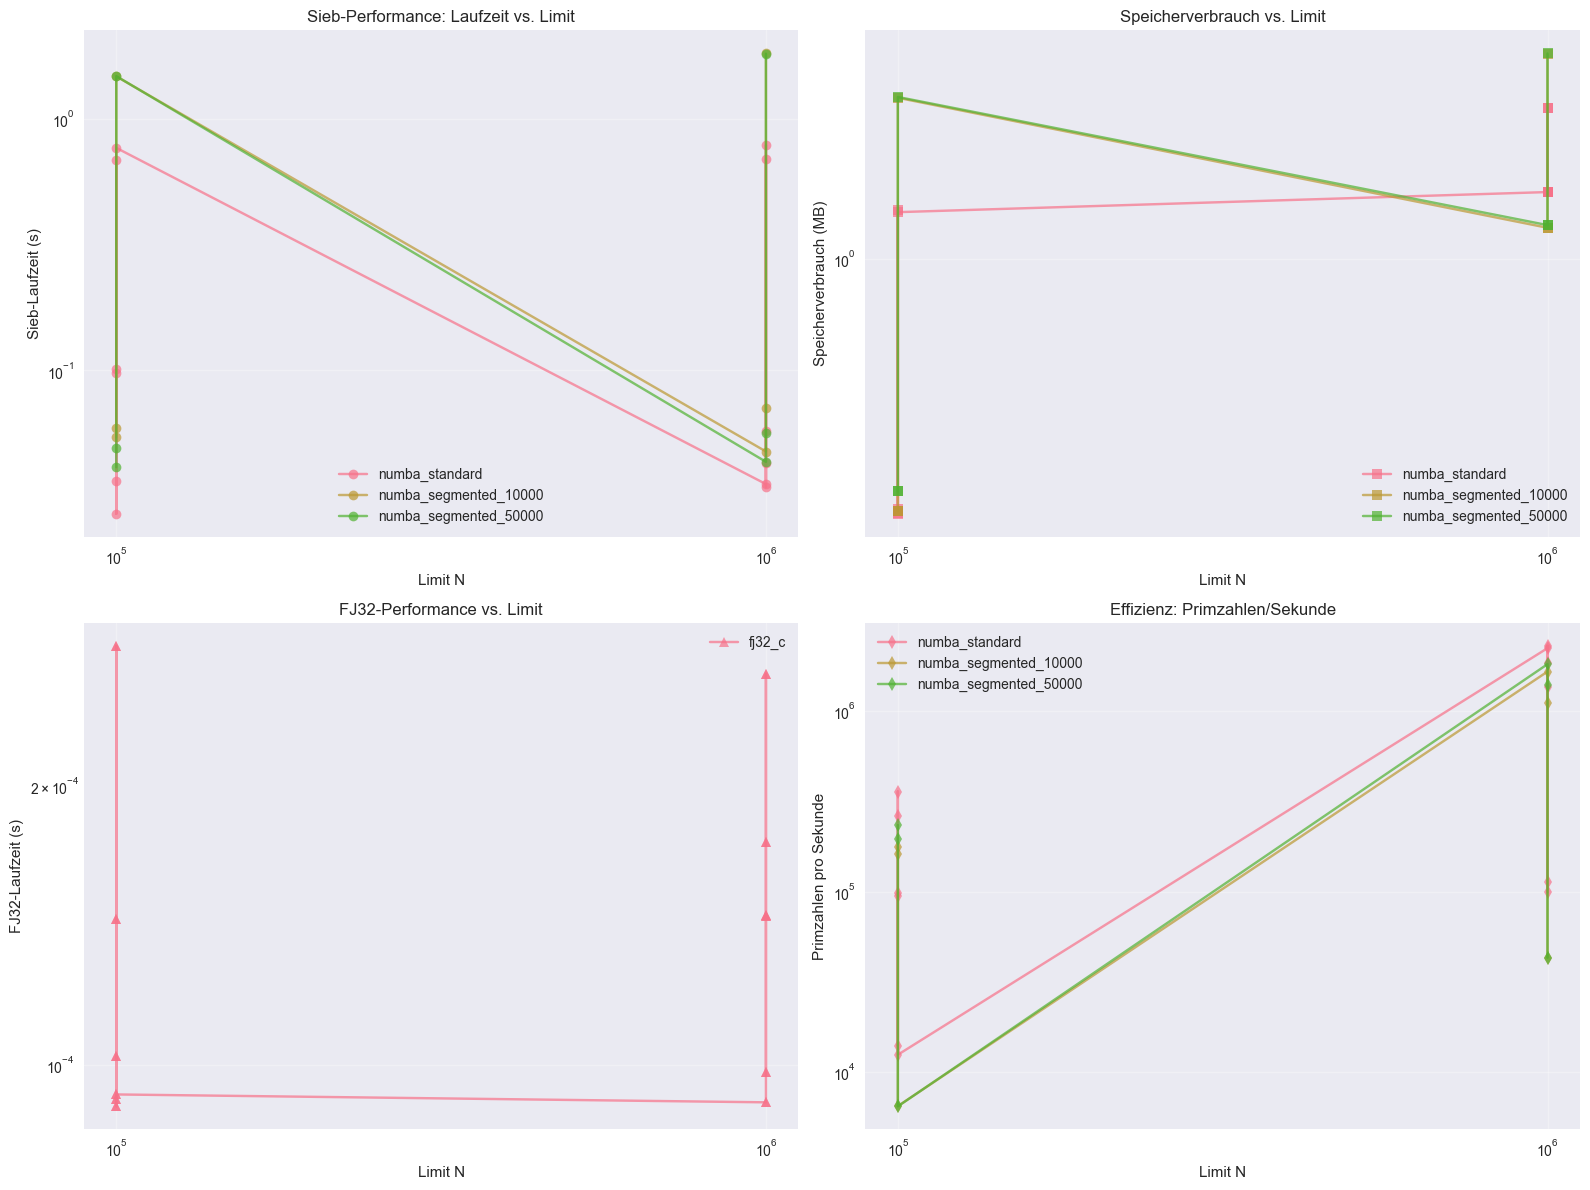

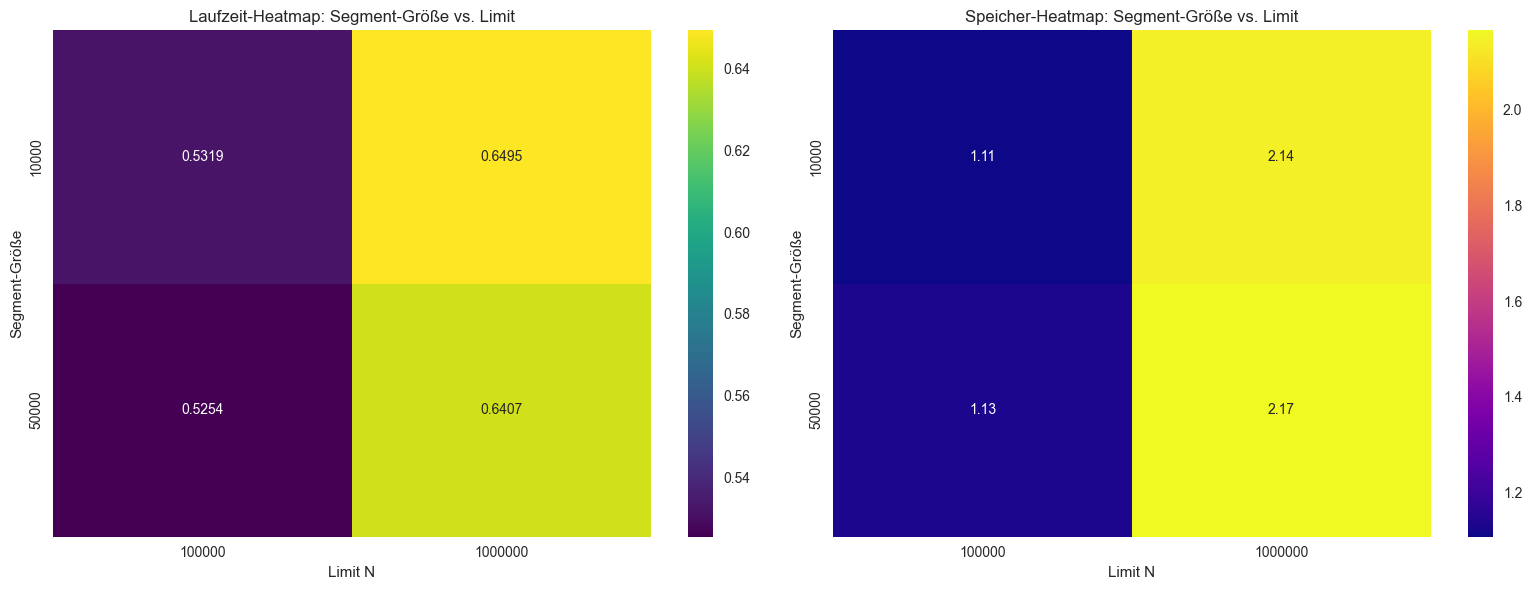

✓ Hauptvisualisierungen erstellt


In [12]:
if not results_df.empty:
    print("📈 Erstelle Visualisierungen...")
    
    # Hauptvisualisierungen mit der Analyzer-Methode
    main_analyzer.create_visualizations(results_df)
    
    print("✓ Hauptvisualisierungen erstellt")
else:
    print("⚠️ Keine Daten für Visualisierungen verfügbar")

### 7.1 Zusätzliche interaktive Plots

📊 Zusätzliche Analysen...


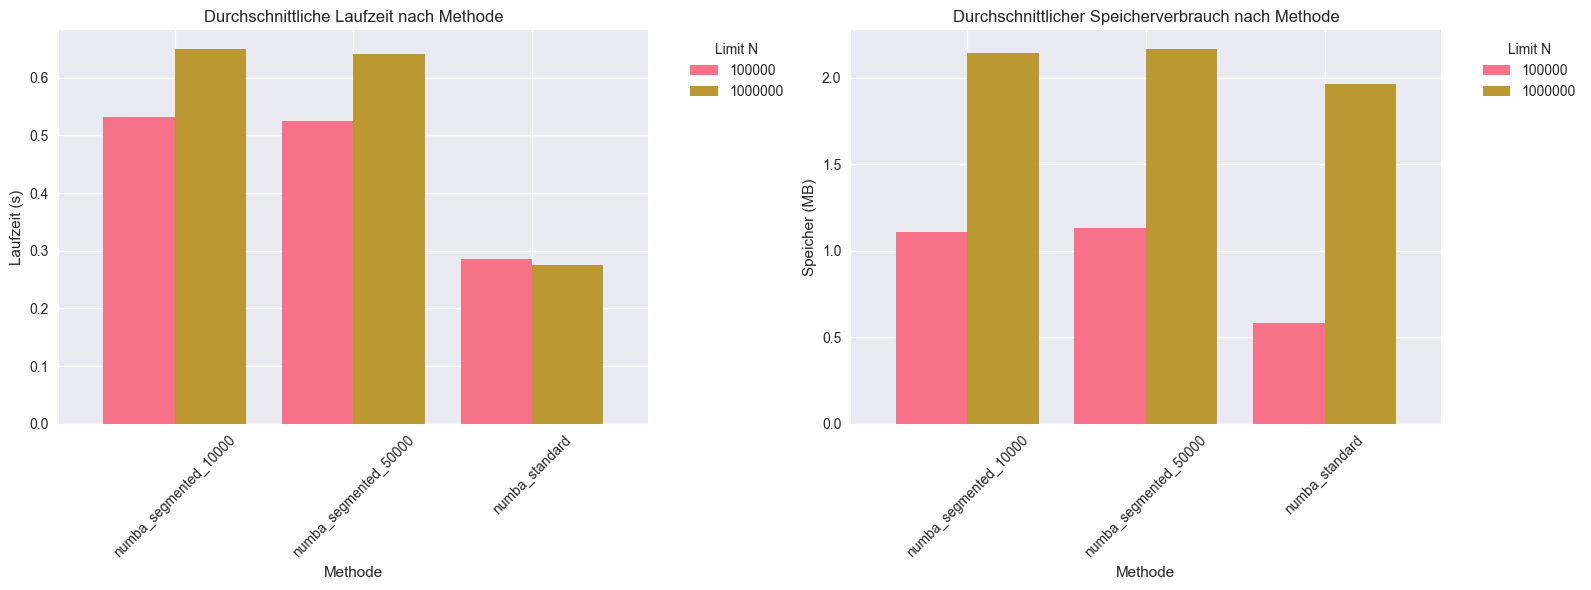


🔍 Korrelations-Analyse


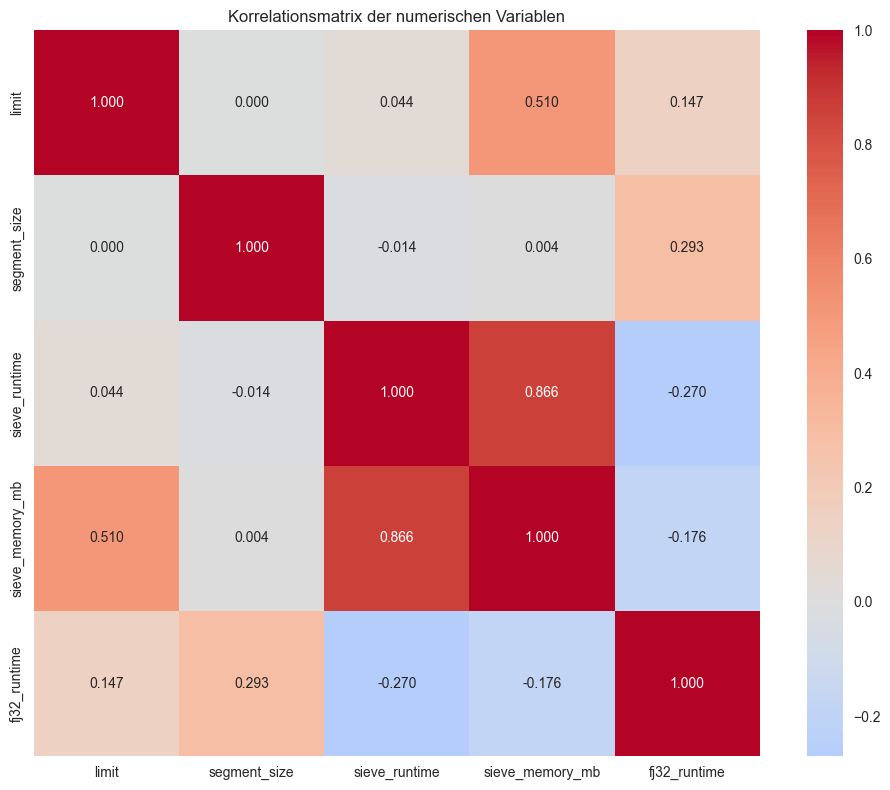

✓ Zusätzliche Analysen abgeschlossen


In [13]:
if not results_df.empty:
    print("📊 Zusätzliche Analysen...")
    
    # Interaktiver Plot: Methoden-Vergleich
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Laufzeit-Vergleich nach Methoden
    method_runtime = results_df.groupby(['method', 'limit'])['sieve_runtime'].mean().unstack()
    method_runtime.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Durchschnittliche Laufzeit nach Methode')
    ax1.set_ylabel('Laufzeit (s)')
    ax1.set_xlabel('Methode')
    ax1.legend(title='Limit N', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Speicher-Vergleich nach Methoden
    method_memory = results_df.groupby(['method', 'limit'])['sieve_memory_mb'].mean().unstack()
    method_memory.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Durchschnittlicher Speicherverbrauch nach Methode')
    ax2.set_ylabel('Speicher (MB)')
    ax2.set_xlabel('Methode')
    ax2.legend(title='Limit N', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Korrelations-Analyse
    print("\n🔍 Korrelations-Analyse")
    numeric_cols = ['limit', 'segment_size', 'sieve_runtime', 'sieve_memory_mb', 'fj32_runtime']
    correlation_matrix = results_df[numeric_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f')
    plt.title('Korrelationsmatrix der numerischen Variablen')
    plt.tight_layout()
    plt.show()
    
    print("✓ Zusätzliche Analysen abgeschlossen")

## 8. Export der Ergebnisse

In [14]:
if not results_df.empty:
    print("💾 Exportiere Ergebnisse...")
    
    # Zeitstempel für eindeutige Dateinamen
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    filename_base = f"modul4_notebook_results_{timestamp}"
    
    # Export mit der Analyzer-Methode
    main_analyzer.export_results(results_df, filename_base)
    
    print(f"\n✅ Alle Dateien exportiert mit Basis-Namen: {filename_base}")
    print("\n📁 Erstellte Dateien:")
    print(f"  📊 plots/modul4_performance_analysis.png")
    print(f"  📊 plots/modul4_heatmaps.png")
    print(f"  📈 data/{filename_base}.csv")
    print(f"  📈 data/{filename_base}.xlsx")
    print(f"  📝 data/{filename_base}_empfehlungen.md")
    
else:
    print("⚠️ Keine Daten zum Exportieren verfügbar")

💾 Exportiere Ergebnisse...
✓ CSV exportiert: data/modul4_notebook_results_20250905_145742.csv


ModuleNotFoundError: No module named 'openpyxl'

## 9. Zusammenfassung und Empfehlungen

In [15]:
if not results_df.empty:
    print("📋 FINALE ZUSAMMENFASSUNG")
    print("=" * 50)
    
    # Allgemeine Statistiken
    total_tests = len(results_df)
    unique_limits = results_df['limit'].nunique()
    unique_methods = results_df['method'].nunique()
    
    print(f"\n📊 Durchgeführte Tests: {total_tests}")
    print(f"📊 Getestete Limits: {unique_limits}")
    print(f"📊 Getestete Methoden: {unique_methods}")
    
    # Performance-Insights
    fastest_overall = results_df.loc[results_df['sieve_runtime'].idxmin()]
    most_memory_efficient = results_df.loc[results_df['sieve_memory_mb'].idxmin()]
    
    print(f"\n🏆 BESTE GESAMTPERFORMANCE:")
    print(f"  Schnellste Konfiguration:")
    print(f"    Methode: {fastest_overall['method']}")
    print(f"    N = {fastest_overall['limit']:,}")
    print(f"    Laufzeit: {fastest_overall['sieve_runtime']:.6f}s")
    print(f"    Speicher: {fastest_overall['sieve_memory_mb']:.2f}MB")
    
    print(f"\n  Speichersparendste Konfiguration:")
    print(f"    Methode: {most_memory_efficient['method']}")
    print(f"    N = {most_memory_efficient['limit']:,}")
    print(f"    Laufzeit: {most_memory_efficient['sieve_runtime']:.6f}s")
    print(f"    Speicher: {most_memory_efficient['sieve_memory_mb']:.2f}MB")
    
    # Numba-Analyse falls verfügbar
    if 'parallel' in results_df.columns and results_df['parallel'].any():
        parallel_avg = results_df[results_df['parallel'] == True]['sieve_runtime'].mean()
        serial_avg = results_df[results_df['parallel'] == False]['sieve_runtime'].mean()
        
        print(f"\n⚡ NUMBA PARALLELISIERUNG:")
        print(f"  Durchschnittliche Laufzeit (Parallel): {parallel_avg:.6f}s")
        print(f"  Durchschnittliche Laufzeit (Serial): {serial_avg:.6f}s")
        if parallel_avg < serial_avg:
            improvement = ((serial_avg - parallel_avg) / serial_avg) * 100
            print(f"  ✅ Verbesserung durch Parallelisierung: {improvement:.1f}%")
        else:
            print(f"  ⚠️ Parallelisierung zeigt keinen Vorteil bei diesen Tests")
    
    print(f"\n🎯 EMPFEHLUNGEN:")
    print(f"  1. Für maximale Geschwindigkeit: {fastest_overall['method']}")
    print(f"  2. Für minimalen Speicherverbrauch: {most_memory_efficient['method']}")
    print(f"  3. Detaillierte Empfehlungen in der generierten Markdown-Datei")
    
    print(f"\n✅ Modul 4 Benchmark-Analyse erfolgreich abgeschlossen!")
    
else:
    print("❌ Keine Ergebnisse für Zusammenfassung verfügbar")
    print("\nTroubleshooting-Schritte:")
    print("1. Überprüfe ob alle benötigten Module installiert sind")
    print("2. Stelle sicher, dass die .venv korrekt aktiviert ist")
    print("3. Prüfe ob primetest.pyd im Arbeitsverzeichnis verfügbar ist")
    print("4. Führe den Benchmark-Abschnitt erneut aus")

📋 FINALE ZUSAMMENFASSUNG

📊 Durchgeführte Tests: 24
📊 Getestete Limits: 2
📊 Getestete Methoden: 3

🏆 BESTE GESAMTPERFORMANCE:
  Schnellste Konfiguration:
    Methode: numba_standard
    N = 100,000
    Laufzeit: 0.026798s
    Speicher: 0.18MB

  Speichersparendste Konfiguration:
    Methode: numba_standard
    N = 100,000
    Laufzeit: 0.036392s
    Speicher: 0.18MB

⚡ NUMBA PARALLELISIERUNG:
  Durchschnittliche Laufzeit (Parallel): 0.059136s
  Durchschnittliche Laufzeit (Serial): 0.621279s
  ✅ Verbesserung durch Parallelisierung: 90.5%

🎯 EMPFEHLUNGEN:
  1. Für maximale Geschwindigkeit: numba_standard
  2. Für minimalen Speicherverbrauch: numba_standard
  3. Detaillierte Empfehlungen in der generierten Markdown-Datei

✅ Modul 4 Benchmark-Analyse erfolgreich abgeschlossen!


---

## Nächste Schritte

Nach erfolgreichem Abschluss von Modul 4:

1. **Ergebnisse reviewen**: Schaue dir die generierten CSV/Excel-Dateien an
2. **Visualisierungen analysieren**: Plots in `plots/` Ordner untersuchen
3. **Empfehlungen lesen**: Markdown-Empfehlungsdatei durchgehen
4. **Optimierungen implementieren**: Beste Konfigurationen in kommende Module integrieren
5. **Dokumentation aktualisieren**: README mit Modul 4 Ergebnissen erweitern

---

*Modul 4 Notebook - Erweiterte Benchmarks & Optimierung*  
*Erstellt für das PRIM-Projekt - September 2025*